<a href="https://colab.research.google.com/github/Albmargar1/ClickbaitDetector/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a name = 'Index'> </a> <font color='orange'> Índice </font>

* [Notas iniciales](#NotasIniciales)
* [Instalación del entorno](#setup) 
* [Parámetros por defecto](#parameters)
* [Funciones principales](#Pipeline)
 * [Análisis descriptivo](#descriptive)
 * [Fine-tuning de modelo pre-entrenado](#finetuning_function)
 * [Evaluación del modelo](#eval_function)
* [Análisis descriptivo de los datos](#preanalysis)
* [Propuesta](#proposal)
* [Entrenamiento usando Fine-tuning](#Fine-tuning): (CUIDADO: largos tiempos de ejecución)
  * [Test clipping de datos si etiqueta dudosa](#M0)
  * 'postText' (Texto del tweet)
    * [Búsqueda de hiperparámetros en BERT](#M1)
    * [Búsqueda de hiperparámetros en RoBERTa](#M2)
    * [Búsqueda de hiperparámetros en XLM-RoBERTa](#M3)
  * 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace)
    * [Búsqueda de hiperparámetros en BERT](#M4)
    * [Búsqueda de hiperparámetros en RoBERTa](#M5)
    * [Búsqueda de hiperparámetros en XLM-RoBERTa](#M6)
* [Evaluación del dataset para cada modelo entrenado](#eval) 
* [Análisis de la solución](#analysis)
  * [Comparación con estado del arte](#soa)
  * [Comparación predicciones con análisis descriptivo inicial](#postanalysis)
  * [Análisis de varios casos de error](#errors)
* [Mejoras y conclusiones](#conclusions)
* [Otras funciones](#Otros)
 * [Subir checkpoint a HuggingFace](#upload)
 * [Liberar cache GPU](#GPU)

# <a name="NotasIniciales"> </a> <font color='orange'> Notas iniciales </font>

<font color='lightgreen'> Comentarios </font>
* # NO EJECUTAR TODAS LAS CELDAS A LA VEZ
Llevará mucho tiempo y posiblemente la GPU se quede sin espacio. Considero que solo hay que tener cuidado con la sección [Entrenamiento usando Fine-tuning](#Fine-tuning).

* Este es el **archivo principal** donde se recogen todas las pruebas. Cada prueba llama a una función dada una configuración de parámetros específica. La mayoría de las funciones se encuentran definidas en la carpeta de `util`.

* El índice contiene enlaces a cada sección para una navegación más cómoda. 

<font color='lightgreen'> Referencias </font>

Quiero mencionar dos proyectos que hacen un trabajo muy parecido. Aunque obtengo ideas de ellos, considero que no hay plagio. Dichos trabajos servirán como referencia para comparar el modelo aquí desarrollado.
* [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT)
* [BERT, XLNet or RoBERTa: The Best Transfer Learning Model to Detect
Clickbaits](https://www.researchgate.net/publication/356276903_BERT_XLNet_or_RoBERTa_The_Best_Transfer_Learning_Model_to_Detect_Clickbaits)


[Volver al índice](#Index)
<a name=setup></a>
# <font color='orange'> Instalación del entorno </font>
Clonar el proyecto, instalar e importar dependencias.

In [1]:
!git clone https://github.com/Albmargar1/ClickbaitDetector -q

fatal: destination path 'ClickbaitDetector' already exists and is not an empty directory.


In [2]:
!pip install -q transformers

In [3]:
!pip install datasets -q folium==0.2.1 # Tengo que especificar la versión de folium o da error al instalar la librería de datasets de Hugging Face

In [4]:
!pip install optuna -q

In [5]:
import sys
sys.path.append('/content/ClickbaitDetector/')

import optuna
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
import datasets
from datasets import load_metric
import torch
from torch.utils.data import DataLoader, SequentialSampler
import numpy as np
import pandas as pd
import copy

from utils import data_processing, descriptive_analysis
from utils.Objective import Objective
from utils.bcolors import bcolors

[Volver al índice](#Index)
<a name='parameters'> </a>
# <font color='orange'> Parámetros por defecto </font>

In [6]:
default_config = {}

# Directories
default_config['train_dir'] = '/content/ClickbaitDetector/data/webis_train.csv'
default_config['test_dir'] = '/content/ClickbaitDetector/data/webis_test.csv'

default_config['logger_transformers'] = 'error'

# Dataset
default_config['train_val_split'] = 0.15
default_config['clip'] = [0.5,0.5]
default_config['inputs'] = ['postText']

# Hyperparameter search
default_config['n_trials'] = 4
default_config['hp'] = {'learning_rate': [1e-5, 5e-5], # Uniform sampling between min-max
                        'epochs': [1,3], # Pick int between min-max
                        'batch_size_train': [16, 32]} # Pick one

# Checkpoint
default_config['checkpoint'] = 'bert-base-uncased'
default_config['model_name'] = default_config['checkpoint'] + '-clickbait'
default_config['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
default_config['cloud_dir'] = 'Stremie/'+ default_config['model_name'] + '-best'

[Volver al índice](#Index)
<a name='Pipeline'> </a>
# <font color='orange'> Funciones principales </font>

Funciones para hacer análisis descriptivo, entrenamiento y evaluación. Consultar la carpeta `utils` para obtener más información de funciones auxiliares.

[Volver al índice](#Index)

<a name=descriptive></a>
<font color='lightgreen'> Análisis descriptivo </font>

In [7]:
def do_descriptive_analysis(data):
  descriptive_analysis.overall_info(data)
  descriptive_analysis.study_std(data)
  descriptive_analysis.probability_clickbait_per_tweet_count_words(data)
  descriptive_analysis.given_word_check_probability_clickbait(data)

[Volver al índice](#Index)
<a name= finetuning_function> </a>

<font color='lightgreen'> Fine-tuning de modelo pre-entrenado </font>

Procesamiento de datos, búsqueda de hiperparámetros y guardado del mejor modelo.

In [8]:
def training(data_dir, p):
  data = data_processing.process_file(data_dir, p['inputs'])

  tokenizer = AutoTokenizer.from_pretrained(p['checkpoint'])
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  data_dic_train = data_processing.to_Dataset(data,
                                              clip=p['clip'],
                                              train_data=True, 
                                              train_val_split = p['train_val_split'])

  tokenized_dataset = data_processing.tokenize_dataset(data_dic_train, 
                                                      tokenizer)
    
  n_clickbaits_train = data_dic_train['train']['labels'].count(1)
  n_noclickbaits_train = data_dic_train['train']['labels'].count(0)
  prop_clickbait =  n_clickbaits_train / n_noclickbaits_train
    
  objective = Objective(p, tokenizer, data_collator, tokenized_dataset, prop_clickbait)
  study = optuna.create_study(study_name=p['model_name'], direction='maximize') 
  study.optimize(objective, n_trials=p['n_trials'], callbacks=[objective.callback]) 
  objective.best_model.save_pretrained(p['finetuned_model_dir'])
  tokenizer.save_pretrained(p['finetuned_model_dir'])

[Volver al índice](#Index)
<a name= eval_function> </a>

<font color='lightgreen'> Evaluación del modelo </font>

Procesamiento de datos y evaluación dado un modelo entrenado.

In [9]:
def model_performance(data_dir, inputs, checkpoint):
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # model
  model = AutoModelForSequenceClassification.from_pretrained(
          checkpoint, num_labels=2, return_dict=True)
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model.to(device)
  model.eval()

  # metric
  metric = datasets.load_metric("glue", "mrpc")

  # load data
  data = data_processing.process_file(data_dir, inputs)
  data_dic = data_processing.to_Dataset(data)

  # tokenize
  tokenized_raw = data_processing.tokenize_dataset(data_dic, tokenizer)

  tokenized = datasets.Dataset.from_dict({
        'input_ids': tokenized_raw['test']['input_ids'],
        'attention_mask': tokenized_raw['test']['attention_mask'],
        'labels': tokenized_raw['test']['labels']})
  

  if 'token_type_ids' in tokenized_raw['test'].features:
    tokenized.add_column('token_type_ids', tokenized_raw['test']['token_type_ids'])

  tokenized.set_format("torch")

  # create loader    
  loader = DataLoader(tokenized, batch_size=32, collate_fn=data_collator)

  # compute overall accuracy and F1-score
  predictions = []
  for batch in loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    logits = outputs.logits
    predictions_batch = torch.argmax(logits, dim=-1)
    predictions = predictions + predictions_batch.tolist()
    metric.add_batch(predictions=predictions_batch, references=batch["labels"])

  results = metric.compute()
  print('Resultados del modelo con checkpoint:', checkpoint)
  print(results)

  return predictions, results

[Volver al índice](#Index)
<a name='preanalysis'></a>
# <font color='orange'> Análisis descriptivo </font>
Se realiza un análisis descriptivo básico, que incluye: 

*   Variabilidad de los anotadores
*   Probabilidad de clickbait en función del número de palabras por tweet
*   Probabilidad de que la palabra pertenezca a un clickbait


In [10]:
data = data_processing.process_file(default_config['train_dir'], ['postText'])
#do_descriptive_analysis(data) # Dejo comentada pues pinta 4 gráficas a la vez
                              # A continuación llamo a las funciones por separado

[Volver al índice](#Index)

<font color='lightgreen'> Descripción de los datos </font>

Existen algunos datos nulos, que se han reemplazado por strings vacíos. No existen tweets mal etiquetados, y la proporción de tweets clickbait respecto al total es considerablemente desproporcionada.

In [11]:
descriptive_analysis.overall_info(data)

 

Tweets legítimos: 14777 
Tweets clickbait: 4761 
Tweets mal etiquetados: 0 
Proporción tweets clickbait: 0.24367898454294196 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19538 entries, 0 to 19537
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         19538 non-null  object
 1   postMedia          19538 non-null  object
 2   postText           19538 non-null  object
 3   id                 19538 non-null  object
 4   targetCaptions     19538 non-null  object
 5   targetParagraphs   19538 non-null  object
 6   targetTitle        19538 non-null  object
 7   postTimestamp      19538 non-null  object
 8   targetKeywords     19538 non-null  object
 9   targetDescription  19538 non-null  object
 10  truthJudgments     19538 non-null  object
 11  truthMean          19538 non-null  object
 12  labels             19538 non-null  object
 13  truthMedian        19538 non-null  object
 14  truth

[Volver al índice](#Index)

<a name =clipping> </a>

<font color='lightgreen'> Variabilidad de los anotadores </font>



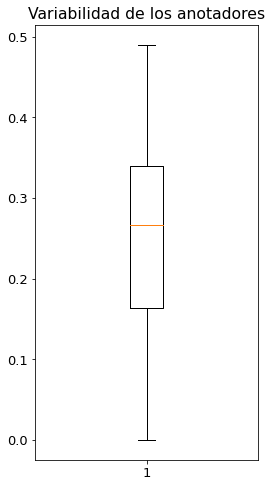

In [12]:
descriptive_analysis.study_std(data)

Resulta interesante observar la variación de las puntuaciones del conjunto de anotadores para cada tweet. Esto puede representarse como un diagrama de cajas de la desviación típica de las puntuaciones.

A la vista de los datos, los anotadores no tienen un consenso muy definido entre sus valoraciones, lo cual podría resultar en confusiones a la hora de entrenar la red neuronal. 

Dado que los mayores valores de desviación típica implica que la correspondiente media está relativamente centrada (uno de los dos casos de mayor desviación típica sería el conjunto de puntuaciones [1, 1, 1, 0, 0], con media = 0.6 y desviación típica ~0.49), resulta relativamente seguro eliminar aquellos datos cuya media de las puntuaciones se encuentre cercana a 0.5.

Esto además nos permite descartar tweets con conjuntos de puntuaciones no polarizados, por ejemplo [0.66, 0.66, 0.66, 0.33, 0.33]. Aunque dicho tweet se considere clickbait, el conjunto de los anotadores no tiene certeza de ello, y puede provocar errores de clasificación durante el entrenamiento.

La cantidad de datos a descartar se tomará como un hiperparámetro. Esto puede perjudicar en que hay un menor número de datos que entrenar, por lo que no resulta obvio que vaya a mejorar el modelo. Por lo tanto, la cantidad de datos a descartar se tomará como un hiperparámetro.

*Nota: Esta idea proviene de este proyecto: [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT/blob/main/Final-Report/EECS498NLP_Project_Final_Report.pdf)*, donde aseguran que mejoran las predicciones.

[Volver al índice](#Index)

<font color='lightgreen'> Probabilidad de clickbait en función del número de palabras por tweet </font>

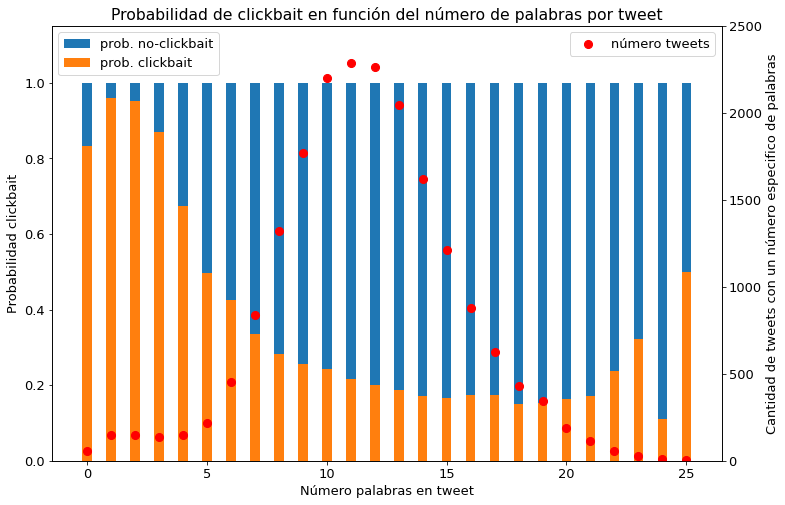

In [13]:
descriptive_analysis.probability_clickbait_per_tweet_count_words(data)

A la vista de la gráfica, podemos observar que la mayoría de tweets con un número de palabras muy bajo suele ser clickbait, y dicha probabilidad tiende a reducirse generalizadamente conforme aumenta el número de palabras. 

[Volver al índice](#Index)

<font color='lightgreen'> Probabilidad de que la palabra aparezca en un clickbait </font>

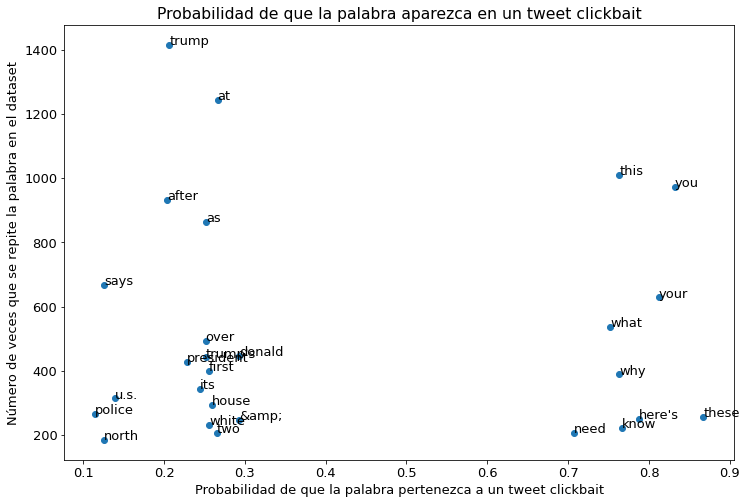

In [14]:
descriptive_analysis.given_word_check_probability_clickbait(data)

Estos resultados no resultan muy reveladores, pero dan pequeñas pistas de qué se puede considerar legítimo y qué puede considerarse clickbait.

Por ejemplo, entre las palabras que más aparecen en los tweets que son clickbaits aparecen apelativos al lector 'you'/'your', preguntas 'what'/'why' y adjetivos demostrativos 'this'/'these'. 

En el caso de tweets legítimos, parece que tiende a poseer palabras menos ambiguas, tales como 'u.s.'/'police'/'trump'/'president'.

Igualmente hay clasificaciones extrañas. Por ejemplo, 'says' se ha catalogado como una palabra que se usa mucho en tweets legítimos, cuando es una palabra que puede recordar a un clickbait.

[Volver al índice](#Index)
<a name=proposal></a>
# <font color='orange'> Propuesta </font>



*   Búsqueda del mejor modelo mediante la búsqueda de hiperparámetros, usando la librería optuna, para diferentes arquitecturas de transformer: `BERT`, `RoBERTa` y `XLM`.
*   Los hiperparámetros están limitados según las recomendaciones (por ejemplo: [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)). La idea es reducir las probabilidades de under y overfitting del modelo, así como mantener un learning rate que estabilice la fase de backpropagation.
*   Adición de una única capa secuencial al vector salida del transformer que permita clasificación.
*   Función a optimizar `CrossEntropyLoss` añadiendo pesos que compensen el desbalance entre clickbaits y no clickbaits. Elección de dicha función al tratarse de un problema de clasificación.
*   F1 y acuraccy como métricas a evaluar para el problema de clasificación, prestando especial atención a F1 pues acuraccy puede dar resultados engañosos en datasets desbalanceados.
*   Entrenamiento de modelos usando como inputs tanto el texto del tweet como el texto del tweet y las palabras claves del texto al que enlaza. Posiblemente esto último no sea del todo correcto si la finalidad es detectar un clickbait sin hacer click en él, pero he hecho pruebas con ello dado que tenía acceso a esos datos.



[Volver al índice](#Index)
<a name=Fine-tuning></a>
# <font color='orange'> Entrenamiento usando Fine-tuning </font> (CUIDADO: largos tiempos de ejecución)


Cada celda a continuación ejecuta el entrenamiento de un modelo concreto.

He tenido problemas de memoria de GPU ya que no se está liberando correctamente entre diferentes entrenamientos. Con BERT y RoBERTa introduciendo el texto del tweet + palabras clave como input. Con XLM los he tenido con los dos inputs. Los he solventado disminuyendo el número de entrenamientos a 1 al realizar la búsqueda de los mejores hiperparámetros

[Volver al índice](#Index)

<a name='M0'></a>
<font color='lightgreen'> Test clipping de datos si etiqueta dudosa </font>

Incluyo un test para entrenar una red que desecha datos de training si la media de los jueces de catalagorar a un tweet como clickbait es cercana a 0.5. Los resultados son peores que los que obtengo sin hacer clipping, por lo que no se tendrá en cuenta en el resto del cuaderno.

[Explicado](#clipping) en la sección anterior

In [ ]:
config_M0 = copy.copy(default_config)
config_M0['checkpoint'] = 'bert-base-uncased'
config_M0['model_name'] = config_M0['checkpoint'] + '-clickbait-clip'
config_M0['finetuned_model_dir'] = './ClickbaitDetector/model/' + config_M0['model_name'] 
config_M0['inputs'] = ['postText']
config_M0['clip'] = [0.4, 0.6]

training(config_M0['train_dir'],config_M0)

predictions, metrics = model_performance(config_M0['test_dir'], ['postText'], checkpoint=config_M0['finetuned_model_dir'])

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-07 09:28:47,605] A new study created in memory with name: bert-base-uncased-clickbait-clip


 
Prueba 1 de 4 
Hiperparámetros para bert-base-uncased 
learning_rate: 1.011042858061678e-05 
epochs: 1 
batch_size_train: 16 


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.390400,0.528243,0.849881,0.688385


[I 2022-04-07 09:33:42,797] Trial 0 finished with value: 0.6883852691218131 and parameters: {'learning_rate': 1.011042858061678e-05, 'epochs': 1, 'batch_size_train': 16}. Best is trial 0 with value: 0.6883852691218131.


 
 F1-score para datos de validación en test 1 = 0.6883852691218131 
 Accuracy para datos de validación en test 1 = 0.8498805868304333 
 
 
Prueba 2 de 4 
Hiperparámetros para bert-base-uncased 
learning_rate: 3.5349356726136284e-05 
epochs: 2 
batch_size_train: 32 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.513611,0.832822,0.685494
2,0.320300,0.723243,0.853292,0.681953


[I 2022-04-07 09:40:15,361] Trial 1 finished with value: 0.6819526627218934 and parameters: {'learning_rate': 3.5349356726136284e-05, 'epochs': 2, 'batch_size_train': 32}. Best is trial 0 with value: 0.6883852691218131.


 
 F1-score para datos de validación en test 2 = 0.6819526627218934 
 Accuracy para datos de validación en test 2 = 0.8532923916751962 
 
 
Prueba 3 de 4 
Hiperparámetros para bert-base-uncased 
learning_rate: 1.7444510888137945e-05 
epochs: 1 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.370900,0.557959,0.856022,0.691069


[I 2022-04-07 09:44:30,865] Trial 2 finished with value: 0.6910688140556369 and parameters: {'learning_rate': 1.7444510888137945e-05, 'epochs': 1, 'batch_size_train': 16}. Best is trial 2 with value: 0.6910688140556369.


 
 F1-score para datos de validación en test 3 = 0.6910688140556369 
 Accuracy para datos de validación en test 3 = 0.8560218355510065 
 
 
Prueba 4 de 4 
Hiperparámetros para bert-base-uncased 
learning_rate: 4.187654681370113e-05 
epochs: 2 
batch_size_train: 32 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.536547,0.832480,0.683430
2,0.317700,0.782638,0.853634,0.679612


[I 2022-04-07 09:51:03,222] Trial 3 finished with value: 0.6796116504854369 and parameters: {'learning_rate': 4.187654681370113e-05, 'epochs': 2, 'batch_size_train': 32}. Best is trial 2 with value: 0.6910688140556369.


 
 F1-score para datos de validación en test 4 = 0.6796116504854369 
 Accuracy para datos de validación en test 4 = 0.8536335721596725 
 


  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo cuyo checkpoint es: ./ClickbaitDetector/model/bert-base-uncased-clickbait-clip
{'accuracy': 0.8656936614152484, 'f1': 0.7242237368819647}


[Volver al índice](#Index)

<a name='M1'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) -- Búsqueda de hiperparámetros en BERT </font>

In [ ]:
config_M1 = copy.copy(default_config)
config_M1['checkpoint'] = 'bert-base-uncased'
config_M1['model_name'] = config_M1['checkpoint'] + '-clickbait'
config_M1['finetuned_model_dir'] = './ClickbaitDetector/model/' + config_M1['model_name'] 
config_M1['inputs'] = ['postText']

training(config_M1['train_dir'],config_M1)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 12:38:10,541] A new study created in memory with name: bert-base-uncased-clickbait


 
Prueba 0 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 4.8763889962463215e-05 
epochs: 1 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.423200,0.378992,0.842375,0.721351


[I 2022-04-06 12:40:44,568] Trial 0 finished with value: 0.721351025331725 and parameters: {'learning_rate': 4.8763889962463215e-05, 'epochs': 1, 'batch_size_train': 16}. Best is trial 0 with value: 0.721351025331725.


 
 F1-score en test 0 = 0.721351025331725 
 Accuracy en test 0 = 0.842374616171955 
 
 
Prueba 1 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 3.881788274425803e-05 
epochs: 2 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.431700,0.400649,0.827021,0.703335
2,0.303900,0.463157,0.853292,0.718586


[I 2022-04-06 12:45:33,935] Trial 1 finished with value: 0.7185863874345549 and parameters: {'learning_rate': 3.881788274425803e-05, 'epochs': 2, 'batch_size_train': 16}. Best is trial 0 with value: 0.721351025331725.


 
 F1-score en test 1 = 0.7185863874345549 
 Accuracy en test 1 = 0.8532923916751962 
 
 
Prueba 2 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 3.4185493262948674e-05 
epochs: 2 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.427200,0.401732,0.833845,0.712684
2,0.298200,0.453267,0.852269,0.722614


[I 2022-04-06 12:50:19,617] Trial 2 finished with value: 0.7226137091607943 and parameters: {'learning_rate': 3.4185493262948674e-05, 'epochs': 2, 'batch_size_train': 16}. Best is trial 2 with value: 0.7226137091607943.


 
 F1-score en test 2 = 0.7226137091607943 
 Accuracy en test 2 = 0.8522688502217673 
 
 
Prueba 3 de 4 
Hiperparámetros para bert-base-uncased : 
learning_rate: 3.968800943614797e-05 
epochs: 3 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.434400,0.416788,0.834869,0.710526
2,0.316600,0.540153,0.852610,0.706522
3,0.196700,0.760798,0.848857,0.691289


[I 2022-04-06 12:57:30,195] Trial 3 finished with value: 0.6912891986062718 and parameters: {'learning_rate': 3.968800943614797e-05, 'epochs': 3, 'batch_size_train': 16}. Best is trial 2 with value: 0.7226137091607943.


 
 F1-score en test 3 = 0.6912891986062718 
 Accuracy en test 3 = 0.8488570453770045 
 


[Volver al índice](#Index)

<a name='M2'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) -- Búsqueda de hiperparámetros en RoBERTa </font>

In [ ]:
config_M2 = copy.copy(default_config)
config_M2['checkpoint'] = 'roberta-base'
config_M2['model_name'] = config_M2['checkpoint'] + '-clickbait'
config_M2['finetuned_model_dir'] = './ClickbaitDetector/model/' + config_M2['model_name'] 
config_M2['inputs'] = ['postText']

training(config_M2['train_dir'],config_M2)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 13:09:09,068] A new study created in memory with name: roberta-base-clickbait


 
Prueba 0 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 4.0963638314565254e-05 
epochs: 2 
batch_size_train: 32 


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.448300,0.451870,0.852610,0.709677
2,0.327600,0.436942,0.843057,0.702842


[I 2022-04-06 13:13:50,017] Trial 0 finished with value: 0.7028423772609819 and parameters: {'learning_rate': 4.0963638314565254e-05, 'epochs': 2, 'batch_size_train': 32}. Best is trial 0 with value: 0.7028423772609819.


 
 F1-score en test 0 = 0.7028423772609819 
 Accuracy en test 0 = 0.8430569771409075 
 
 
Prueba 1 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 4.09141014526183e-05 
epochs: 1 
batch_size_train: 32 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.436300,0.390105,0.832139,0.699634


[I 2022-04-06 13:16:11,549] Trial 1 finished with value: 0.6996336996336997 and parameters: {'learning_rate': 4.09141014526183e-05, 'epochs': 1, 'batch_size_train': 32}. Best is trial 0 with value: 0.7028423772609819.


 
 F1-score en test 1 = 0.6996336996336997 
 Accuracy en test 1 = 0.8321392016376663 
 
 
Prueba 2 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 2.14168003397444e-05 
epochs: 3 
batch_size_train: 32 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.447200,0.436278,0.851928,0.708725
2,0.343100,0.486890,0.851928,0.712583
3,0.272000,0.498258,0.847834,0.703063


[I 2022-04-06 13:22:58,287] Trial 2 finished with value: 0.7030625832223701 and parameters: {'learning_rate': 2.14168003397444e-05, 'epochs': 3, 'batch_size_train': 32}. Best is trial 2 with value: 0.7030625832223701.


 
 F1-score en test 2 = 0.7030625832223701 
 Accuracy en test 2 = 0.8478335039235756 
 
 
Prueba 3 de 4 
Hiperparámetros para roberta-base : 
learning_rate: 3.110030998183404e-05 
epochs: 1 
batch_size_train: 16 


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.410200,0.400335,0.847492,0.715105


[I 2022-04-06 13:25:41,399] Trial 3 finished with value: 0.7151051625239006 and parameters: {'learning_rate': 3.110030998183404e-05, 'epochs': 1, 'batch_size_train': 16}. Best is trial 3 with value: 0.7151051625239006.


 
 F1-score en test 3 = 0.7151051625239006 
 Accuracy en test 3 = 0.8474923234390993 
 


[Volver al índice](#Index)

<a name='M3'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) -- Búsqueda de hiperparámetros en XLM-RoBERTa </font>

In [ ]:
config_M3 = copy.copy(default_config)
config_M3['checkpoint'] = 'xlm-roberta-base'
config_M3['model_name'] = config_M3['checkpoint'] + '-clickbait'
config_M3['finetuned_model_dir'] = './ClickbaitDetector/model/' + config_M3['model_name'] 
config_M3['inputs'] = ['postText']
config_M3['n_trials'] = 1

config_M3['hp'] = {'learning_rate': [1e-5, 5e-5], 
                   'epochs': [2,4], 
                   'batch_size_train': [16, 32]} 

training(config_M3['train_dir'],config_M3)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 19:28:05,865] A new study created in memory with name: xlm-roberta-base-clickbait


 
Prueba 1 de 1 
Hiperparámetros para xlm-roberta-base 
learning_rate: 2.368107665238697e-05 
epochs: 3 
batch_size_train: 32 


Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.464000,0.424016,0.798704,0.662085
2,0.374700,0.460488,0.854657,0.690856
3,0.314900,0.456768,0.833845,0.681074


[I 2022-04-06 19:44:30,618] Trial 0 finished with value: 0.6810740013097576 and parameters: {'learning_rate': 2.368107665238697e-05, 'epochs': 3, 'batch_size_train': 32}. Best is trial 0 with value: 0.6810740013097576.


 
 F1-score para datos de validación en test 1 = 0.6810740013097576 
 Accuracy para datos de validación en test 1 = 0.8338451040600477 
 


[Volver al índice](#Index)

<a name='M4'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en BERT </font>

Recomiendo volver a empezar una sesión nueva. Ocupa mucho espacio en GPU.

In [ ]:
config_M4 = copy.copy(default_config)
config_M4['checkpoint'] = 'bert-base-uncased'
config_M4['n_trials'] = 1
config_M4['model_name'] = config_M4['checkpoint'] + '-clickbait-keywords'
config_M4['finetuned_model_dir'] = './ClickbaitDetector/model/' + config_M4['model_name'] 
config_M4['inputs'] = ['postText', 'targetKeywords']
config_M4['hp'] = {'learning_rate': [3e-5, 3e-5], 
                        'epochs': [2,2], 
                        'batch_size_train': [8]} 

training(config_M4['train_dir'],config_M4)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 15:59:01,868] A new study created in memory with name: bert-base-uncased-clickbait-keywords-


 
Prueba 1 de 1 
Hiperparámetros para bert-base-uncased 
learning_rate: 3e-05 
epochs: 2 
batch_size_train: 8 


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.441600,0.460537,0.847151,0.697297
2,0.341400,0.664456,0.849539,0.693963


[I 2022-04-06 16:20:46,496] Trial 0 finished with value: 0.6939625260235947 and parameters: {'learning_rate': 3e-05, 'epochs': 2, 'batch_size_train': 8}. Best is trial 0 with value: 0.6939625260235947.


 
 F1-score para datos de validación en test 1 = 0.6939625260235947 
 Accuracy para datos de validación en test 1 = 0.849539406345957 
 


[Volver al índice](#Index)

<a name='M5'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en RoBERTa </font>

In [ ]:
config_M5 = copy.copy(default_config)
config_M5['checkpoint'] = 'roberta-base'
config_M5['n_trials'] = 1
config_M5['model_name'] = config_M5['checkpoint'] + '-clickbait-keywords'
config_M5['finetuned_model_dir'] = './ClickbaitDetector/model/' + config_M5['model_name'] 
config_M5['inputs'] = ['postText', 'targetKeywords']
config_M5['hp'] = {'learning_rate': [3e-5, 3e-5], 
                        'epochs': [2,2], 
                        'batch_size_train': [8]} 

training(config_M5['train_dir'],config_M5)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

[I 2022-04-06 16:33:28,171] A new study created in memory with name: roberta-base-clickbait-keywords


 
Prueba 1 de 1 
Hiperparámetros para roberta-base 
learning_rate: 3e-05 
epochs: 2 
batch_size_train: 8 


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.523500,0.667688,0.849198,0.673560
2,0.441800,0.558655,0.858751,0.685888


[I 2022-04-06 16:57:22,710] Trial 0 finished with value: 0.6858877086494689 and parameters: {'learning_rate': 3e-05, 'epochs': 2, 'batch_size_train': 8}. Best is trial 0 with value: 0.6858877086494689.


 
 F1-score para datos de validación en test 1 = 0.6858877086494689 
 Accuracy para datos de validación en test 1 = 0.8587512794268168 
 


[Volver al índice](#Index)

<a name='M6'></a>
<font color='lightgreen'> 'postText' (Texto del tweet) + 'targetKeywords' (Palabras claves del enlace) -- Búsqueda de hiperparámetros en XLM-RoBERTa </font>

In [ ]:
config_M6 = copy.copy(default_config)
config_M6['checkpoint'] = 'xlm-roberta-base'
config_M6['n_trials'] = 1
config_M6['model_name'] = config_M6['checkpoint'] + '-clickbait-keywords'
config_M6['finetuned_model_dir'] = './ClickbaitDetector/model/' + config_M6['model_name'] 
config_M6['inputs'] = ['postText', 'targetKeywords']
config_M6['hp'] = {'learning_rate': [3e-5, 3e-5], 
                        'epochs': [2,2], 
                        'batch_size_train': [8]} 

training(config_M6['train_dir'],config_M6)

[Volver al índice](#Index)
<a name=eval></a>
# <font color='orange'> Evaluación del dataset para cada modelo entrenado </font>

Puedes usar cualquier checkpoint recién entrenado cambiando el argumento `checkpoint='checkpoint_dir'`, sustituyendo por el número del modelo que viene indicado en las celdas. (Ejecutarlo puede durar unos 20 minutos debido a que descarga 6 modelos de Hugging Face).

In [ ]:
checkpoint_1 = 'bert-base-uncased-clickbait'
predictions_1, metrics_1 = model_performance(default_config['test_dir'], 
                                             ['postText'],
                                             checkpoint=str('Stremie/'+checkpoint_1))

checkpoint_2 = 'roberta-base-clickbait'
predictions_2, metrics_2 = model_performance(default_config['test_dir'], 
                                             ['postText'], 
                                             checkpoint=str('Stremie/'+checkpoint_2))

checkpoint_3 = 'xlm-roberta-base-clickbait'
predictions_3, metrics_3 = model_performance(default_config['test_dir'], 
                                             ['postText'], 
                                             checkpoint=str('Stremie/'+checkpoint_3))

checkpoint_4 = 'bert-base-uncased-clickbait-keywords'
predictions_4, metrics_4 = model_performance(default_config['test_dir'], 
                                            ['postText', 'targetKeywords'], 
                                             checkpoint=str('Stremie/'+checkpoint_4))

checkpoint_5 = 'roberta-base-clickbait-keywords'
predictions_5, metrics_5 = model_performance(default_config['test_dir'], 
                                             ['postText', 'targetKeywords'], 
                                             checkpoint=str('Stremie/'+checkpoint_5))

checkpoint_6 = 'xlm-roberta-base-clickbait-keywords'
predictions_6, metrics_6 = model_performance(default_config['test_dir'], 
                                             ['postText', 'targetKeywords'], 
                                             checkpoint=str('Stremie/'+checkpoint_6))

results = {}
results[checkpoint_1] = {'predictions': predictions_1, 'metrics': metrics_1}
results[checkpoint_2] = {'predictions': predictions_2, 'metrics': metrics_2}
results[checkpoint_3] = {'predictions': predictions_3, 'metrics': metrics_3}
results[checkpoint_4] = {'predictions': predictions_4, 'metrics': metrics_4}
results[checkpoint_5] = {'predictions': predictions_5, 'metrics': metrics_5}
results[checkpoint_6] = {'predictions': predictions_6, 'metrics': metrics_6}

  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo con checkpoint: Stremie/bert-base-uncased-clickbait
{'accuracy': 0.8593708836081986, 'f1': 0.7301041561330771}


  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo con checkpoint: Stremie/roberta-base-clickbait
{'accuracy': 0.8556299067390274, 'f1': 0.7329955174429936}


Downloading:   0%|          | 0.00/435 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo con checkpoint: Stremie/xlm-roberta-base-clickbait
{'accuracy': 0.8556825965540861, 'f1': 0.7302806499261448}


Downloading:   0%|          | 0.00/367 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo con checkpoint: Stremie/bert-base-uncased-clickbait-keywords
{'accuracy': 0.8682227725380683, 'f1': 0.726097908224729}


Downloading:   0%|          | 0.00/394 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Resultados del modelo con checkpoint: Stremie/roberta-base-clickbait-keywords
{'accuracy': 0.8704884345855946, 'f1': 0.7170810313075506}


Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/815 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

Los resultados se muestran en la siguiente tabla: 

In [ ]:
labels = [model for model in results]
metrics = [[results[model]['metrics']['f1'], results[model]['metrics']['accuracy']] for model in results]
columns = ['F1', 'accuracy']
df = pd.DataFrame(metrics, index=labels, columns=columns)
df

Los modelos poseen unas métricas muy parecidas. Vamos a comprobar si los modelos hacen las mismas predicciones a un conjunto de datos, o si por el contrario tienen métricas parecidas pero variando qué datos son clickbaits y cuáles no:

In [ ]:
predictions = [results[model]['predictions'] for model in results]

model_size = len(predictions)
pred_size = len(predictions[0])

overlapping_predictions = np.zeros((model_size, model_size))
for i in range(model_size):
  for j in range(i,model_size):
    coincidences = [1 if predictions[i][k] == predictions[j][k] else 0 for k in range(pred_size)]
    overlapping_predictions[i,j] = sum(coincidences) / pred_size 
    overlapping_predictions[j,i] = overlapping_predictions[i,j]

labels = [model for model in results]

df = pd.DataFrame(overlapping_predictions, index=labels, columns=labels)
df

Todos los modelos poseen un conjunto de predicciones similares entorno al 91% y 93%. Esto significa que las predicciones son muy parecidas (dado que los valores de precisión y F1 son altos), pero existen diferencias entre las predicciones de todos ellos.


[Volver al índice](#Index)
<a name=solution></a>
# <font color='orange'> Análisis de la solución</font>

Considero el modelo `roberta-base-cased-clickbait` el mejor entrenado en este proyecto (F1=0.7330 y acuraccy 0.8556) pues, aunque presente el menor acuraccy, presenta el mayor F1, lo cual es una métrica más valorada cuando el dataset de clickbaits no está balanceado. Este modelo va a predecir peor los no-clickbaits que otros modelos entrenados en este proyecto, pero mejor los clickbaits.

<a name=soa></a>
<font color='lightgreen'> Comparación con estado del arte </font>

Comparando el modelo `roberta-base-cased-clickbait` con otras referencias:

[Webis 17 clickbait challenge](https://webis.de/events/clickbait-challenge/shared-task.html#results)

El modelo posee el segundo mejor F1 y el quinto mejor acuraccy. Estos resultados tan buenos resultan lógicos pues los transformers se diseñaron en 2017 y en dicho challenge se diseñaron otro tipo de arquitecturas. 

[BERT, XLNet or RoBERTa: The Best Transfer Learning Model to Detect Clickbaits](https://www.researchgate.net/publication/356276903_BERT_XLNet_or_RoBERTa_The_Best_Transfer_Learning_Model_to_Detect_Clickbaits)

Sus modelos poseen peores métricas, dado que su mejor F1 es 0.6938 con acuraccy 0.8459 (XLNet con múltiples capas densas a la salida del transformer). Sin dudar la calidad de dicho artículo, pone en duda si añadir alguna arquitectura más sencilla a la salida del transformer mejora las predicciones.

[Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT)

Presentan un modelo muy interesante, que es combinar el texto del tweet con BERT y el contenido del artículo con un longformer (4000 tokens de input). No aplican Fine-tuning, pero introducen una red LSTM bidireccional. Su F1 es de 0.715 y acuraccy 0.8872. Posee un acuraccy muy alto para un valor de F1 tan bueno comparado con los 6 modelos aquí entrenados, y creo que su modelo es de una calidad similar a nuestro mejor modelo. 

[Volver al índice](#Index)

<a name=postanalysis></a>
<font color='lightgreen'> Comparación predicciones datos entrenamiento con análisis descriptivo inicial </font>

Resulta interesante volver a ejecutar el análisis descriptivo inicial pero, en lugar de usar las verdaderas etiquetas, usar las etiquetas predichas por el modelo. De esta forma podemos comprobar si el modelo ha aprendido los patrones que se detectaron al principio.

In [ ]:
checkpoint = 'roberta-base-clickbait'
predictions, metrics = model_performance(default_config['train_dir'], ['postText'], checkpoint=str('Stremie/'+checkpoint))

data = data_processing.process_file(default_config['train_dir'], ['postText'])
data['labels'] = predictions 

In [ ]:
data = data_processing.process_file(default_config['train_dir'], ['postText'])
data['labels'] = predictions 

In [ ]:
descriptive_analysis.probability_clickbait_per_tweet_count_words(data)

Sin entrar en los números exactos, el modelo entrenado tiende más a catalogar como clickbaits tweets con pocas palabras (de 0 a 2 palabras los considera siempre clickbait), lo cual es una limitación de nuestro modelo (aunque cabe dudar cómo pueden existir tweets sin texto que puedan ser considerados no clickbaits). La tendencia es la misma que vimos en el análisis inicial: conforme aumenta el número de palabras disminuye la probabilidad de ser clickbait. Para un alto número de palabras la tendencia va aumentando, pero también el número de tweets con un alto número de palabras es bastante menor. 

In [ ]:
descriptive_analysis.given_word_check_probability_clickbait(data)

Muchas de las palabras catalogadas ya aparecían en el análisis inicial. Destacar apariciones en clickbaits de palabras como `'most'/'best'/'should'/'make'/'can'`... Considero lógicos la mayoría de los resultados mostrados.

[Volver al índice](#Index)

<a name=errors></a>
<font color='lightgreen'> Análisis de varios casos de error </font>

Se incluyen los cinco primeros casos de predicciones erróneas, usando tanto el modelo 'roberta-base-cased-clickbait' como el modelo 'roberta-base-cased-clickbait-keywords', por si hubiese diferencias al añadir palabras clave.

PD: No modificar nada, pues se explican tweets escogidos al azar (los cinco primeros mal predichos) y si cambian los mal predichos, las explicaciones no se corresponderán con el tweet.

In [ ]:
checkpoint_1 = 'roberta-base-clickbait'
predictions_1, metrics_1 = model_performance(default_config['test_dir'], ['postText'], checkpoint=str('Stremie/'+checkpoint_1))

checkpoint_2 = 'roberta-base-clickbait-keywords'
predictions_2, metrics_2 = model_performance(default_config['test_dir'], ['postText', 'targetKeywords'], checkpoint=str('Stremie/'+checkpoint_2))

data_1 = data_processing.process_file(default_config['test_dir'], ['postText'])
data_1['predicted-including-keywords'] = predictions_2
data_1['bad_predicted'] = [abs(data_1['labels'][i] - predictions_1[i]) for i in range(data_1.shape[0])]
data_masked = data_1.loc[data_1['bad_predicted'].values==1].reset_index()

In [ ]:
print('Texto:', data_masked['postText'][0]) 
print('Verdadera etiqueta:', 'clickbait' if data_masked['labels'][0] == 1 else 'no-clickbait')
print('Predicción modelo que incluye las palabras claves:', 'clickbait' if data_masked['predicted-including-keywords'][0] == 1 else 'no-clickbait')

Dicho tweet se ha considerado clickbait y creo que es por el contenido `tense moment`, que hace referencia a una emoción importante, muy propicio de los clickbaits.

Usando el modelo que incluye palabras claves también se cataloga como clickbait.

In [ ]:
print('Texto:', data_masked['postText'][1]) 
print('Verdadera etiqueta:', 'clickbait' if data_masked['labels'][1] == 1 else 'no-clickbait')
print('Predicción modelo que incluye las palabras claves:', 'clickbait' if data_masked['predicted-including-keywords'][1] == 1 else 'no-clickbait')

Otro tweet mal catalogado como clickbait, y creo que es por las palabras `Don't` `you` `want`, que están asociadas según el modelo a clickbaits.

Usando el modelo que incluye palabras claves también se cataloga como clickbait.

In [ ]:
print('Texto:', data_masked['postText'][2]) 
print('Verdadera etiqueta:', 'clickbait' if data_masked['labels'][2] == 1 else 'no-clickbait')
print('Predicción modelo que incluye las palabras claves:', 'clickbait' if data_masked['predicted-including-keywords'][2] == 1 else 'no-clickbait')

Otra vez, tweet mal catalogado como clickbait. Hace referencia a un hito pasado y pregunta al lector cuál es el hito actual. Creo que sería imposible que, solo con el contenido del tweet, el modelo pudiese catalogar este tweet como no-clickbait.

De hecho, el modelo que incluye palabras claves lo ha catalogado como no-clickbait, por lo que debe haber una gran relación entre el tweet y las palabras claves del texto.

In [ ]:
print('Texto:', data_masked['postText'][3]) 
print('Verdadera etiqueta:', 'clickbait' if data_masked['labels'][3] == 1 else 'no-clickbait')
print('Predicción modelo que incluye las palabras claves:', 'clickbait' if data_masked['predicted-including-keywords'][3] == 1 else 'no-clickbait')

Este tweet se catalogó como no-clickbait pues puede hacer referencia a una feliciticación entre dos conocidos.

La predicción del modelo que incluye las palabras claves lo detecta como clickbait. No existirá una relación aparente entre el contenido del tweet y sus palabras claves.

In [ ]:
print('Texto:', data_masked['postText'][4]) 
print('Verdadera etiqueta:', 'clickbait' if data_masked['labels'][4] == 1 else 'no-clickbait')
print('Predicción modelo que incluye las palabras claves:', 'clickbait' if data_masked['predicted-including-keywords'][4] == 1 else 'no-clickbait')

Catalogado como no-clickbait por los dos modelos. Supongo que el tweet en sí puede hacer referencia a un posible titular real, y que las palabras claves están relacionadas con el contenido del tweet.

[Volver al índice](#Index)
<a name=conclusions></a>
# <font color='orange'> Mejoras y conclusiones </font>

<font color='lightgreen'> Posible trabajo futuro </font>
*   Ejecución de tests incluyendo diferentes arquitecturas después del vector salida del transformer. No tengo certeza que esto vaya a mejorar los resultados pues el transformer es más complejo que cualquier capa que pueda diseñar, pero no he hecho dichas pruebas.  
*   Mejora de la gestión de memoria en GPU.
*   Añadir otros inputs a la red, como el contenido del texto al que enlaza, que no lo he podido probar en una arquitectura longformer (capacidad hasta ~4000 tokens) pues no tenía memoria en GPU.



<font color='lightgreen'> Conclusiones </font>
*   Dadas las comparaciones con el estado del arte para este mismo dataset, considero que se han calculado buenos modelos para la predección de clickbaits, y que los modelos entrenados pueden usarse como comparaciones en otros futuros proyectos.
*   La adición de `CrossEntropyLoss` con pesos ponderados ha sido clave, aumentando el F1-score en varios puntos porcentuales. La búsqueda de hiperparámetros ha ayudado a no tener que encontrar el mejor modelo manualmente.
*   La adición de palabras claves al contenido del tweet no ha mejorado el modelo como en un principio habría esperado. Posiblemente haya algún error en el preprocesamiento de los datos.

[Volver al índice](#Index)
<a name=Otros></a>
# <font color='orange'> Otras funciones </font>

[Volver al índice](#Index)

<a name=upload></a>
<font color='lightgreen'> Subir checkpoint a HuggingFace </font>

In [ ]:
!pip install huggingface_hub -q
!sudo apt-get install git-lfs -q

!huggingface-cli login

from huggingface_hub import notebook_login
notebook_login()

In [ ]:
def push_model_to_hub(dir, name):
  model = AutoModelForSequenceClassification.from_pretrained(
              dir, num_labels=2, return_dict=True)
  tokenizer = AutoTokenizer.from_pretrained(dir)

  model.push_to_hub(name, use_temp_dir=True)
  tokenizer.push_to_hub(name, use_temp_dir=True)

In [ ]:
push_model_to_hub(config_M6['finetuned_model_dir'], 'M6')

[Volver al índice](#Index)

<a name=GPU></a>
<font color='lightgreen'> Liberar cache GPU </font>

In [ ]:
torch.cuda.empty_cache()